# Exercise Session 2
## Hold Out, Early Stopping and Cross Validation

### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
%cd /gdrive/My Drive/polimi/artificialneuraldeep

/gdrive/My Drive/polimi/artificialneuraldeep


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load data 

In [7]:
wine=pd.read_csv('winequality.csv',sep=';')
print(wine.info())
wine.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  colour                6497 non-null   int64  
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB
None


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1,5


In [8]:
wine.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994669,3.218501,0.531268,10.491759,0.246114,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002898,0.160787,0.148806,1.192711,0.430779,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,0.000000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,0.000000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.000000,4.010000,2.000000,14.900000,1.000000,9.000000


Split in train and test

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(wine[wine.columns[:-1]], pd.DataFrame(wine['quality'], columns=['quality']), test_size = 0.1, random_state=seed, stratify=pd.DataFrame(wine['quality'], columns=['quality']))
print(X_train_val.shape, y_train_val.shape)
print(X_test.shape, y_test.shape)


(5847, 12) (5847, 1)
(650, 12) (650, 1)


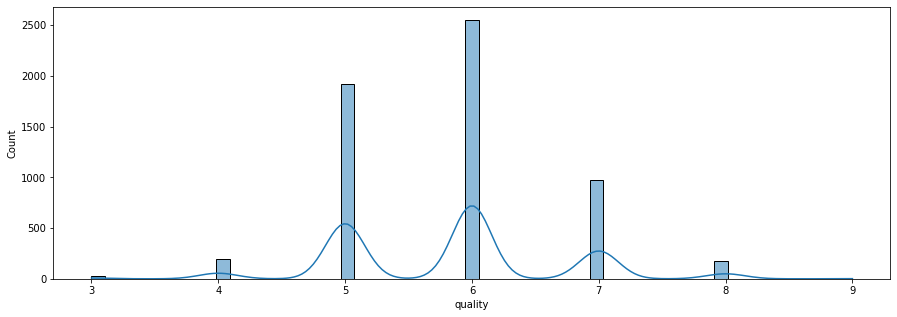

In [11]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=y_train_val, x='quality', kde=True)
plt.show()

### Process data

In [12]:
# Normalize both features and target
max_df = X_train_val.max()
min_df = X_train_val.min()
max_t = y_train_val.max()
min_t = y_train_val.min()

X_train_val = (X_train_val - min_df)/(max_df - min_df)
y_train_val = (y_train_val - min_t)/(max_t - min_t)

print('Wine dataset shape',X_train_val.shape)
print('Target shape', y_train_val.shape)
X_train_val.describe()

Wine dataset shape (5847, 12)
Target shape (5847, 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,colour
count,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000
mean,0.276339,0.173106,0.191695,0.074527,0.078151,0.102764,0.253806,0.588173,0.386211,0.170552,0.358848,0.245596
std,0.107338,0.110280,0.087618,0.073116,0.058595,0.061566,0.130555,0.224487,0.124580,0.083916,0.172344,0.430477
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.208333,0.100000,0.150602,0.018405,0.048173,0.055556,0.165899,0.410396,0.302326,0.112994,0.217391,0.000000
50%,0.258333,0.140000,0.186747,0.036810,0.063123,0.097222,0.258065,0.604344,0.379845,0.158192,0.333333,0.000000
75%,0.316667,0.213333,0.234940,0.115031,0.093023,0.139757,0.345622,0.767261,0.465116,0.209040,0.478261,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


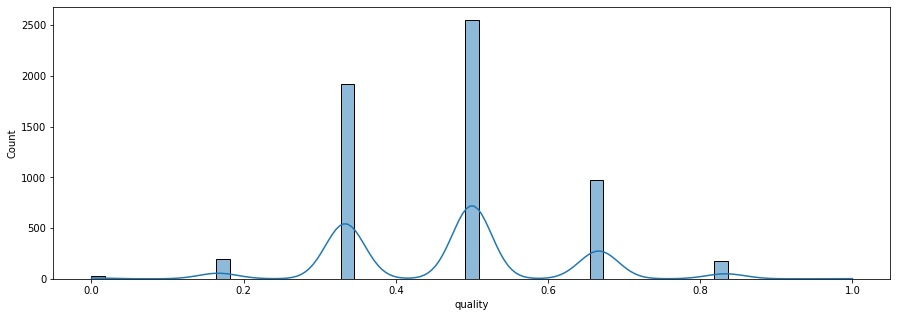

In [13]:
# Inspect the target after normalization
plt.figure(figsize=(15,5))
sns.histplot(data=y_train_val, x='quality', kde=True)
plt.show()

In [14]:
# Normalize the test set with the same parameters of training set
X_test = (X_test - min_df)/(max_df - min_df)
y_test = (y_test - min_t)/(max_t - min_t)

## Hold Out

In [24]:
input_shape=X_train_val.shape[1:]
batch_size=256
epochs=1000

In [15]:
def monitor(histories, names, colors, early_stopping=1):
    assert len(histories) == len(names)
    assert len(histories) == len(colors)
    plt.figure(figsize=(15,6))
    for idx in range(len(histories)):
        plt.plot(histories[idx]['mse'][:-early_stopping], label=names[idx]+' Training', alpha=.4, color=colors[idx], linestyle='--')
        plt.plot(histories[idx]['val_mse'][:-early_stopping], label=names[idx]+' Validation', alpha=.8, color=colors[idx])   
    plt.ylim(0.0075, 0.02)
    plt.title('Mean Squared Error')
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid(alpha=.3)
    plt.show()

In [16]:
def plot_residuals(model, X_, y_):
    X_['sort'] = y_
    X_ = X_.sort_values(by=['sort'])
    y_ = np.expand_dims(X_['sort'], 1)
    X_.drop(['sort'], axis=1, inplace=True)

    y_pred = model.predict(X_)
    MSE = mean_squared_error(y_,y_pred)

    print('Mean Squared Error (MSE): %.4f' % MSE)

    mpl.rcParams.update(mpl.rcParamsDefault)
    sns.set(font_scale=1.1, style=None, palette='Set1')
    plt.figure(figsize=(15,5))
    plt.scatter(np.arange(len(y_pred)), y_pred, label='Prediction', color='#1f77b4')
    plt.scatter(np.arange(len(y_)), y_, label='True', color='#d62728')
    
    for i in range(len(y_)):
        if(y_[i]>=y_pred[i]):
            plt.vlines(i,y_pred[i],y_[i],alpha=.5)
        else:
            plt.vlines(i,y_[i],y_pred[i],alpha=.5)
            
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

In [17]:
histories=[]
names=[]
colors=[]
val_scores=[]
test_scores=[]

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = len(X_test), random_state=seed, stratify=y_train_val)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5197, 12) (5197, 1)
(650, 12) (650, 1)


### Default model

In [22]:
def build_default_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    hidden_layer1 = tfkl.Dense(units=256, activation='relu', name='Hidden1', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(input_layer)
    hidden_layer2 = tfkl.Dense(units=128, activation='relu', name='Hidden2', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(hidden_layer1)
    hidden_layer3 = tfkl.Dense(units=64, activation='relu', name='Hidden3', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(hidden_layer2)
    output_layer = tfkl.Dense(units=1, activation='linear', name='Output', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(hidden_layer3)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='default_model')

    # Compile the model
    learning_rate = 1e-3
    opt = tfk.optimizers.Adam(learning_rate)
    loss = tfk.losses.MeanSquaredError()
    mtr = ['mse']
    model.compile(loss=loss, optimizer=opt, metrics=mtr)

    # Return the model
    return model

Model: "default_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12)]              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 256)               3328      
_________________________________________________________________
Hidden2 (Dense)              (None, 128)               32896     
_________________________________________________________________
Hidden3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
_________________________________________________________________


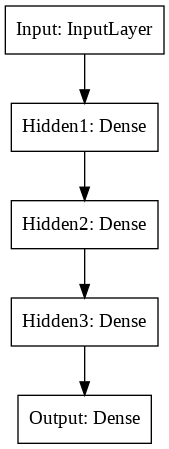

In [25]:
default_model = build_default_model(input_shape)
default_model.summary()
tfk.utils.plot_model(default_model)

In [26]:
default_history = default_model.fit(
    x = X_train,
    y = y_train, 
    validation_data=(X_val, y_val),
    batch_size = batch_size,
    epochs = epochs
).history

Epoch 1/1000
21/21 [==============================] - 1s 16ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 2/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 3/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 5/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 6/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 7/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 8/1000
21/21 [==============================] - 0s 6ms/step - loss: 0

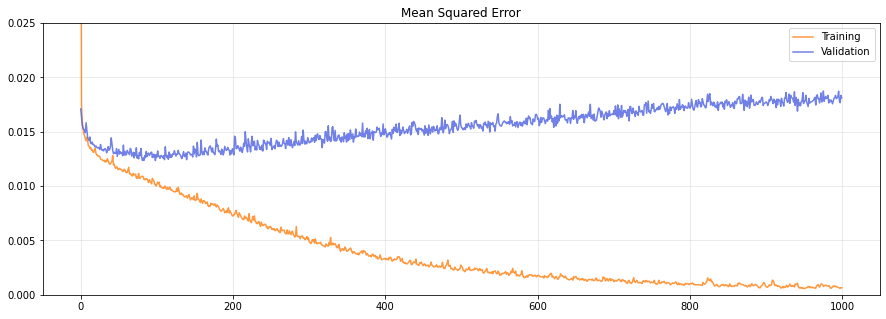

In [27]:
plt.figure(figsize=(15,5))
plt.plot(default_history['mse'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(default_history['val_mse'], label='Validation', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.025)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

Train Performance
Mean Squared Error (MSE): 0.0005


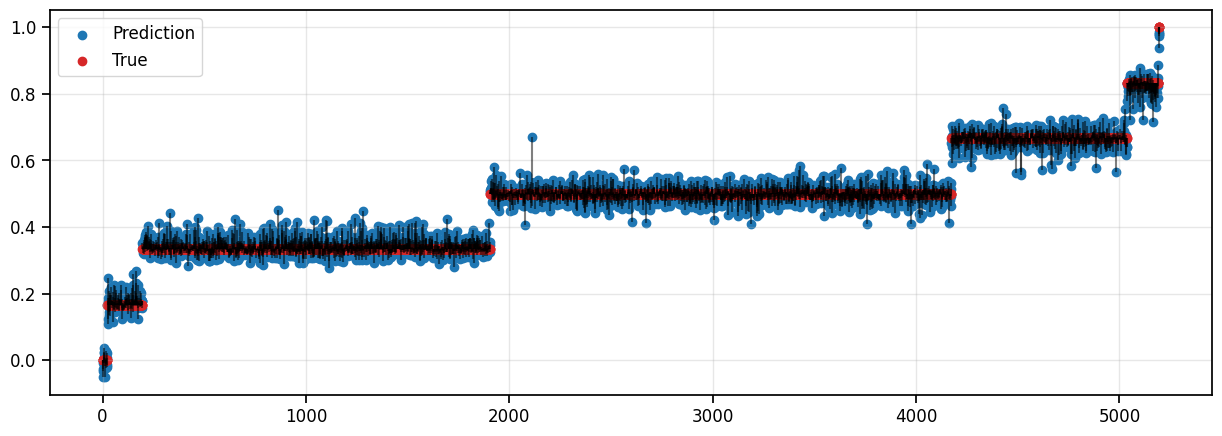

Validation Performance
Mean Squared Error (MSE): 0.0181


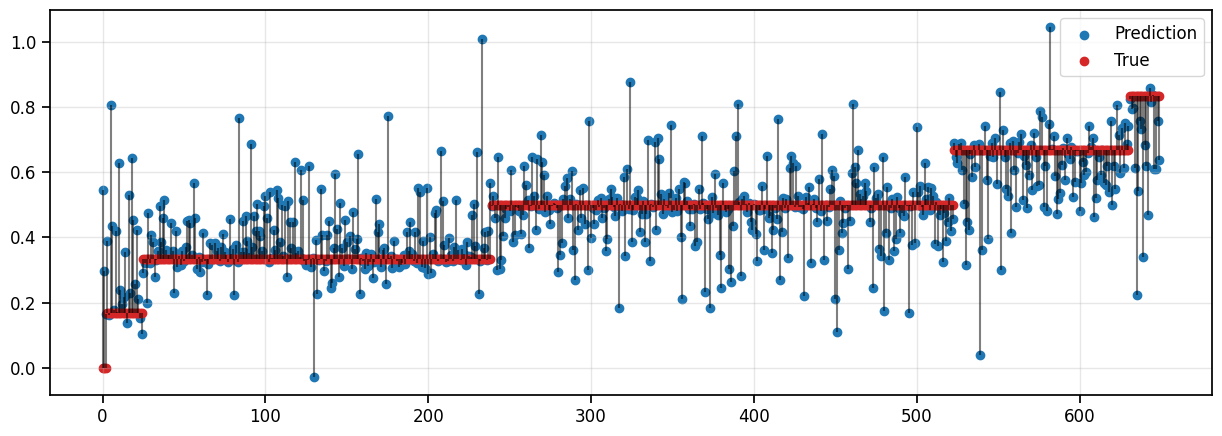

In [28]:
print('Train Performance')
plot_residuals(default_model, X_train.copy(), y_train.copy())
print('Validation Performance')
plot_residuals(default_model, X_val.copy(), y_val.copy())

#### Early Stopping

In [29]:
patience = 150
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_mse', mode='min', patience=patience, restore_best_weights=True)

Model: "default_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12)]              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 256)               3328      
_________________________________________________________________
Hidden2 (Dense)              (None, 128)               32896     
_________________________________________________________________
Hidden3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
_________________________________________________________________


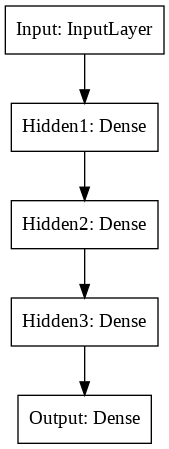

In [30]:
earlystopping_model = build_default_model(input_shape)
earlystopping_model.summary()
tfk.utils.plot_model(earlystopping_model)

In [31]:
earlystopping_history = earlystopping_model.fit(
    x = X_train,
    y = y_train, 
    validation_data=(X_val, y_val),
    batch_size = batch_size,
    epochs = epochs,
    callbacks=[early_stopping]
).history

Epoch 1/1000
21/21 [==============================] - 1s 16ms/step - loss: 0.0468 - mse: 0.0468 - val_loss: 0.0171 - val_mse: 0.0171
Epoch 2/1000
21/21 [==============================] - 0s 7ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 3/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 4/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0153 - val_mse: 0.0153
Epoch 5/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 6/1000
21/21 [==============================] - 0s 5ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 7/1000
21/21 [==============================] - 0s 6ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 8/1000
21/21 [==============================] - 0s 7ms/step - loss: 0

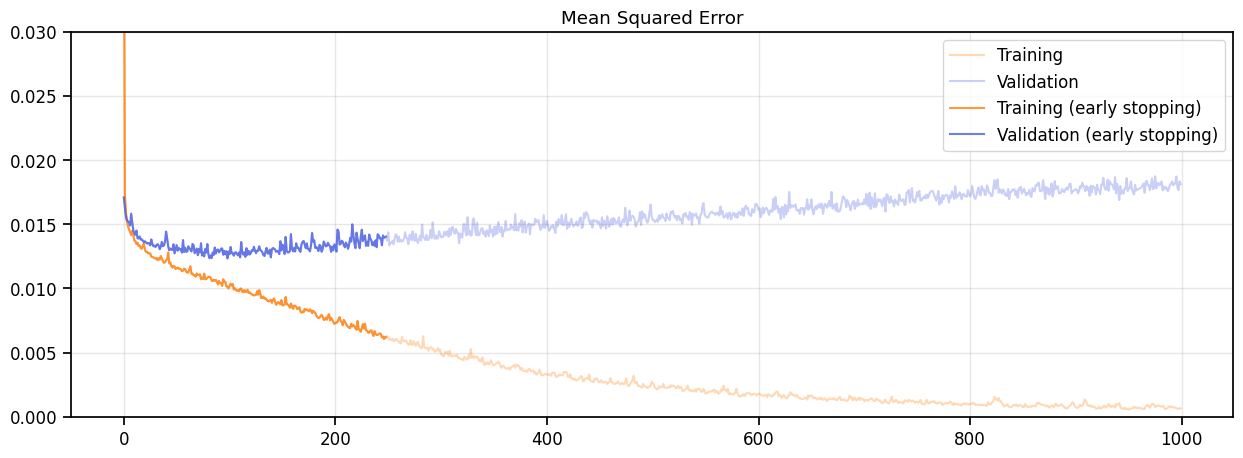

In [32]:
plt.figure(figsize=(15,5))
plt.plot(default_history['mse'], label='Training', alpha=.3, color='#ff7f0e')
plt.plot(default_history['val_mse'], label='Validation', alpha=.3, color='#4D61E2')
plt.plot(earlystopping_history['mse'], label='Training (early stopping)', alpha=.8, color='#ff7f0e')
plt.plot(earlystopping_history['val_mse'], label='Validation (early stopping)', alpha=.8, color='#4D61E2')
plt.ylim(0, 0.03)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

Train Performance
Mean Squared Error (MSE): 0.0098


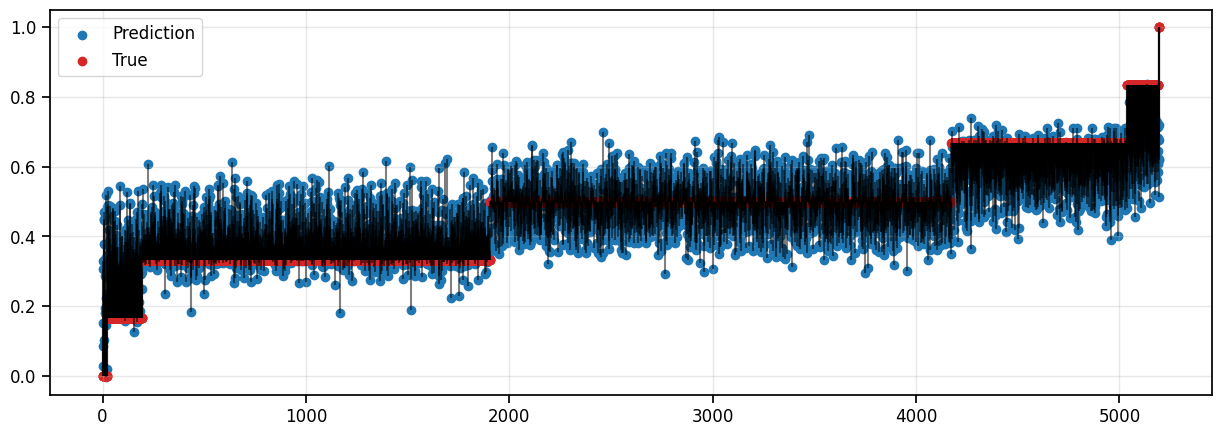

Validation Performance
Mean Squared Error (MSE): 0.0123


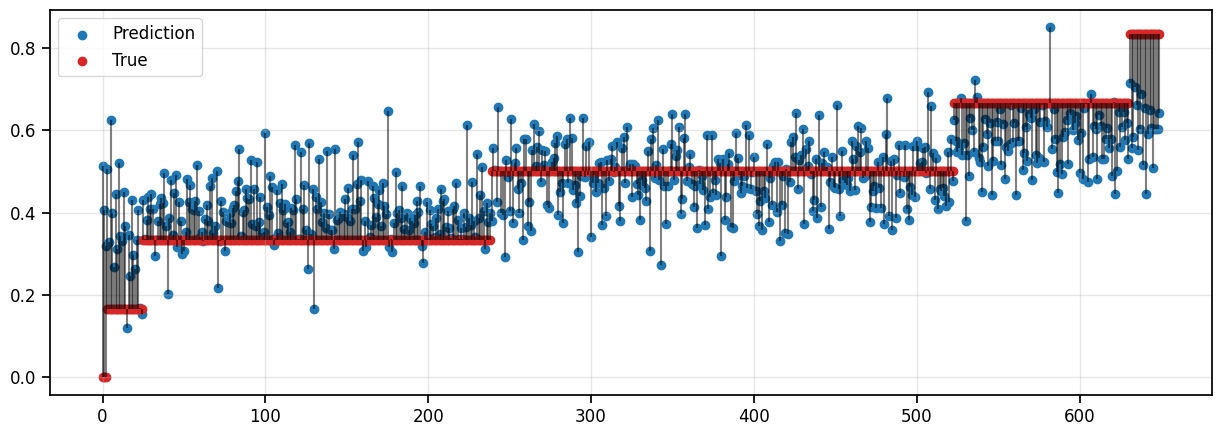

In [33]:
print('Train Performance')
plot_residuals(earlystopping_model, X_train.copy(), y_train.copy())
print('Validation Performance')
plot_residuals(earlystopping_model, X_val.copy(), y_val.copy())

Validation MSE 0.0123


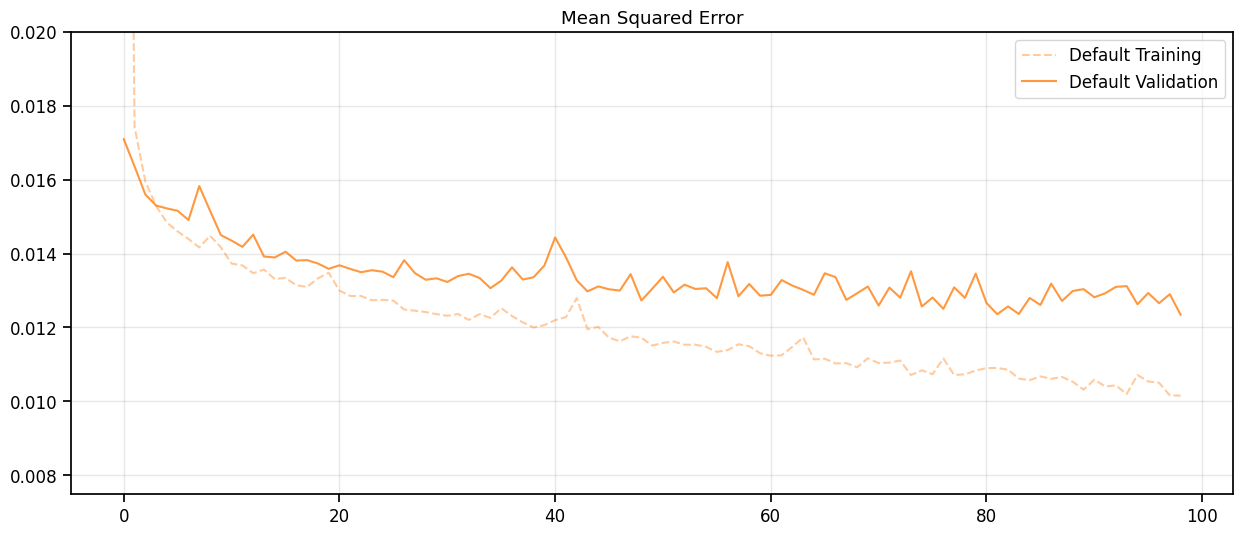

In [34]:
# Store results
val_scores.append(mean_squared_error(y_val, earlystopping_model.predict(X_val)))
print('Validation MSE %.4f' % val_scores[0])
test_scores.append(mean_squared_error(y_test, earlystopping_model.predict(X_test)))
histories.append(earlystopping_history)
names.append('Default')
colors.append('#ff7f0e')
monitor(histories, names, colors, patience)

Save, delete and load a Keras model

In [ ]:
earlystopping_model.save('DefaultModel')

In [ ]:
del earlystopping_model

## Regularization techniques

### Weight decay (or l2-norm or Ridge regression)

$$\mathrm{WD} (y, \hat{y}) = \frac{1}{N} \sum^N_{n=0} (y_n - g(x_n|w))^2 + \lambda\sum^K_{k=0}w_k^2 = \mathrm{MSE} (y, \hat{y}) + \lambda||w||_2^2
$$

In [ ]:
def build_l2_model(input_shape):

    # Build the neural network layer by layer


    # Connect input and output through the Model class


    # Compile the model


    # Return the model


In [ ]:
# Store results


### Dropout

In [ ]:
def build_dropout_model(input_shape):

    # Build the neural network layer by layer


    # Connect input and output through the Model class


    # Compile the model

    # Return the model


In [ ]:
# Store results


### Dropout + l2-norm

In [ ]:
def build_dropout_l2_model(input_shape):

    # Build the neural network layer by layer

    # Connect input and output through the Model class

    # Compile the model

    # Return the model
    

In [ ]:
# Store results


In [ ]:
plt.figure(figsize=(15,6))
plt.plot(default_history['val_mse'], alpha=.3, color='#ff7f0e')
plt.plot(earlystopping_history['val_mse'][:-patience], alpha=.8, color='#ff7f0e', label='Default')
plt.plot(history_l2['val_mse'], alpha=.3, color='#4D61E2')
plt.plot(history_l2['val_mse'][:-patience], alpha=.8, color='#4D61E2', label='Weight Decay')
plt.plot(history_dropout['val_mse'], alpha=.3, color='#7DD667')
plt.plot(history_dropout['val_mse'][:-patience], alpha=.8, color='#7DD667', label='Dropout')
plt.plot(history_dropoutl2['val_mse'], alpha=.3, color='#B951D0')
plt.plot(history_dropoutl2['val_mse'][:-patience], alpha=.8, color='#B951D0', label='Dropout + Weight Decay')
plt.ylim(0.0115, 0.025)
plt.title('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

#K-Fold

In [ ]:
from sklearn.model_selection import KFold

num_folds = 10

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']